In [2]:
import torch
import hw2
import hw2_utils
import torch.nn as nn
%pylab inline
#style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from sklearn.datasets import load_digits
from os import listdir
import re
from PIL import Image
from torchvision import transforms

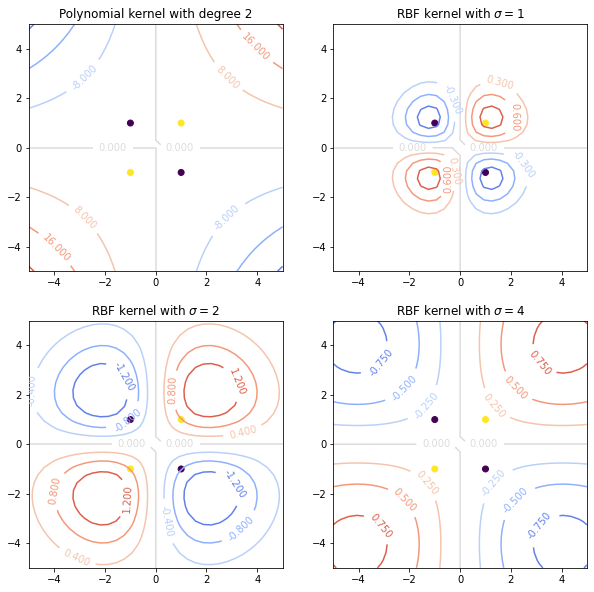

In [5]:
figure(figsize=(10,10))

xmin=-5; xmax=5; ymin=-5; ymax=5; ngrid = 33
x_train, y_train = hw2_utils.xor_data()

subplot(2,2,1)
alpha = hw2.svm_solver(x_train, y_train, lr=0.01, num_iters=1000,kernel=hw2_utils.poly(degree=2), c=None)

with torch.no_grad():
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    
    x_test = torch.cat((xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),dim = 2).view(-1, 2)
    
    zz = hw2.svm_predictor(alpha, x_train, y_train, x_test,kernel=hw2_utils.poly(degree=2))
    
    zz = zz.view(ngrid, ngrid)
    cs = contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(), cmap = 'coolwarm')
    clabel(cs)
    scatter(x_train[:,0],x_train[:,1],c=y_train)
    title('Polynomial kernel with degree 2')
    
    
subplot(2,2,2)
alpha = hw2.svm_solver(x_train, y_train, lr=0.01, num_iters=1000,kernel=hw2_utils.rbf(sigma=1), c=None)

with torch.no_grad():
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    
    x_test = torch.cat((xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),dim = 2).view(-1, 2)
    
    zz = hw2.svm_predictor(alpha, x_train, y_train, x_test,kernel=hw2_utils.rbf(sigma=1))
    
    zz = zz.view(ngrid, ngrid)
    cs = contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(), cmap = 'coolwarm')
    clabel(cs)
    scatter(x_train[:,0],x_train[:,1],c=y_train)
    title('RBF kernel with $\sigma=1$')
    
    
subplot(2,2,3)
alpha = hw2.svm_solver(x_train, y_train, lr=0.01, num_iters=1000,kernel=hw2_utils.rbf(sigma=2), c=None)

with torch.no_grad():
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    
    x_test = torch.cat((xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),dim = 2).view(-1, 2)
    
    zz = hw2.svm_predictor(alpha, x_train, y_train, x_test,kernel=hw2_utils.rbf(sigma=2))
    
    zz = zz.view(ngrid, ngrid)
    cs = contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(), cmap = 'coolwarm')
    clabel(cs)
    scatter(x_train[:,0],x_train[:,1],c=y_train)
    title('RBF kernel with $\sigma=2$')
    
    
subplot(2,2,4)
alpha = hw2.svm_solver(x_train, y_train, lr=0.01, num_iters=1000,kernel=hw2_utils.rbf(sigma=4), c=None)

with torch.no_grad():
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid((xgrid, ygrid))
    
    x_test = torch.cat((xx.view(ngrid, ngrid, 1), yy.view(ngrid, ngrid, 1)),dim = 2).view(-1, 2)
    
    zz = hw2.svm_predictor(alpha, x_train, y_train, x_test,kernel=hw2_utils.rbf(sigma=4))
    
    zz = zz.view(ngrid, ngrid)
    cs = contour(xx.cpu().numpy(), yy.cpu().numpy(), zz.cpu().numpy(), cmap = 'coolwarm')
    clabel(cs)
    scatter(x_train[:,0],x_train[:,1],c=y_train)
    title('RBF kernel with $\sigma=4$')

In [6]:
class CAFENet(nn.Module):
    def __init__(self):
        '''
            Initialize the CAFENet by calling the superclass' constructor
            and initializing a linear layer to use in forward().

            Arguments:
                self: This object.
        '''
        super(CAFENet, self).__init__()
        
        [COL,ROW] = hw2_utils.IMAGE_DIMS
        self.fc = torch.nn.Linear(COL*ROW, 6) # Linear(input_dim, output_dim)

    def forward(self, x):
        '''
            Computes the network's forward pass on the input tensor.
            Does not apply a softmax or other activation functions.

            Arguments:
                self: This object.
                x: The tensor to compute the forward pass on.
        '''
        return self.fc(x)

def fit(net, X, y, n_epochs=5000):
    '''
    Trains the neural network with CrossEntropyLoss and an Adam optimizer on
    the training set X with training labels Y for n_epochs epochs.

    Arguments:
        net: The neural network to train
        X: n x d tensor
        y: n x 1 tensor
        n_epochs: The number of epochs to train with batch gradient descent.

    Returns:
        List of losses at every epoch, including before training
        (for use in plot_cafe_loss).
    '''
    results = torch.zeros(n_epochs+1)
    
    optimizer = torch.optim.Adam(net.parameters())
    loss_function = torch.nn.CrossEntropyLoss()
    
    results[0] = loss_function(net(X),y).item()
    
    #for input, target in dataset:
    #    optimizer.zero_grad()
    #    output = model(input)
    #    loss = loss_fn(output, target)
    #    loss.backward()
    #    optimizer.step()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        output = net(X)
        loss = loss_function(output,y)
        results[i+1] = loss.item()
        loss.backward()
        optimizer.step()
        
    return results

In [12]:
net = CAFENet()

In [13]:
X,y = hw2_utils.get_cafe_data()

In [14]:
#loss = fit(net,X,y,n_epochs=200)
fit(net,X,y,n_epochs=10)

tensor([ 1.8348,  1.8348, 52.5539, 75.1361, 35.4283, 34.9536, 45.4173, 78.4829,
        65.3887, 81.9287, 73.1143])

Text(0.5, 1.0, 'CAFENet losses w/ epoches')

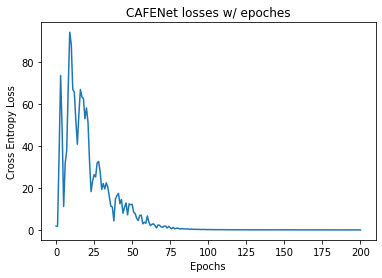

In [11]:
plot(loss)
xlabel('Epochs')
ylabel('Cross Entropy Loss')
title('CAFENet losses w/ epoches')

In [9]:
weights = net.fc.weight.detach()
print(weights.shape)

torch.Size([6, 91200])


In [10]:
min_weight, max_weight = torch.min(weights), torch.max(weights)
print(min_weight,max_weight)

tensor(-0.0175) tensor(0.0224)


In [11]:
weights = ((weights - min_weight) * 255 / (max_weight - min_weight)).int()

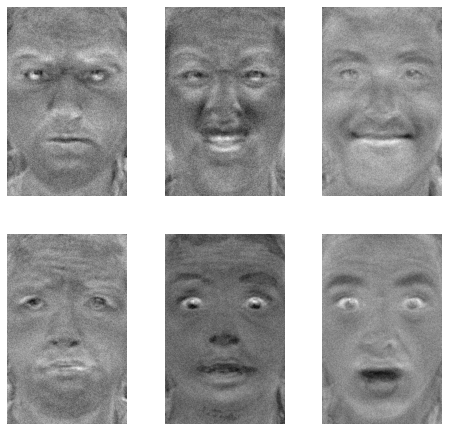

In [12]:
figure(figsize = [240/30.,230/30.])

for i in range(6):
    subplot(2,3,i+1)
    imshow(torch.reshape(weights[i], hw2_utils.IMAGE_DIMS), cmap='gray')
    axis('off')

In [13]:
import hw2_utils
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [24]:
class DigitsConvNet(nn.Module):
    def __init__(self):
        '''
        Initializes the layers of your neural network by calling the superclass
        constructor and setting up the layers.

        You should use nn.Conv2d, nn.MaxPool2D, and nn.Linear
        The layers of your neural network (in order) should be
        1) a 2D convolutional layer with 1 input channel and 8 outputs, with a kernel size of 3, followed by
        2) a 2D maximimum pooling layer, with kernel size 2
        3) a 2D convolutional layer with 8 input channels and 4 output channels, with a kernel size of 3
        4) a fully connected (Linear) layer with 4 inputs and 10 outputs
        '''
        super(DigitsConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, 3)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(8, 4, 3)
        self.fc = torch.nn.Linear(4, 10)

    def forward(self, xb):
        '''
        A forward pass of your neural network.

        Note that the nonlinearity between each layer should be F.relu.  You
        may need to use a tensor's view() method to reshape outputs

        Arguments:
            self: This object.
            xb: An (N,8,8) torch tensor.

        Returns:
            An (N, 10) torch tensor
        '''
        x = torch.unsqueeze(xb,1) # input 1
        
        x = self.conv1(x) # output 8
        x = F.relu(x)

        x = self.pool(x) 

        x = self.conv2(x) # output 4
        x = F.relu(x)
        
        x = self.fc(x.view(x.size(0), -1)) # output 10
        
        return x

def fit_and_evaluate(net, optimizer, loss_func, train, test, n_epochs, batch_size=1):
    '''
    Fits the neural network using the given optimizer, loss function, training set
    Arguments:
        net: the neural network
        optimizer: a optim.Optimizer used for some variant of stochastic gradient descent
        train: a torch.utils.data.Dataset
        test: a torch.utils.data.Dataset
        n_epochs: the number of epochs over which to do gradient descent
        batch_size: the number of samples to use in each batch of gradient descent

    Returns:
        train_epoch_loss, test_epoch_loss: two arrays of length n_epochs+1,
        containing the mean loss at the beginning of training and after each epoch
    '''
    train_dl = torch.utils.data.DataLoader(train, batch_size)
    test_dl = torch.utils.data.DataLoader(test)

    train_losses = []
    test_losses = []

    # Compute the loss on the training and validation sets at the start,
    # being sure not to store gradient information (e.g. with torch.no_grad():)
    
    with torch.no_grad():
        train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
        test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))

    # Train the network for n_epochs, storing the training and validation losses
    # after every epoch. Remember not to store gradient information while calling
    # epoch_loss

    for i in range(n_epochs):
        for xb, yb in train_dl:
            hw2_utils.train_batch(net, loss_func, xb, yb, optimizer)
            
        with torch.no_grad():
            train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
            test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))

    return train_losses, test_losses

#-------------------------------------
#-------------------------------------
#-------------------------------------

def fit_and_evaluate_2(net, loss_func, train, test, n_epochs, batch_size=1):
    '''
    Fits the neural network using the given optimizer, loss function, training set
    Arguments:
        net: the neural network
        optimizer: a optim.Optimizer used for some variant of stochastic gradient descent
        train: a torch.utils.data.Dataset
        test: a torch.utils.data.Dataset
        n_epochs: the number of epochs over which to do gradient descent
        batch_size: the number of samples to use in each batch of gradient descent

    Returns:
        train_epoch_loss, test_epoch_loss: two arrays of length n_epochs+1,
        containing the mean loss at the beginning of training and after each epoch
    '''
    train_dl = torch.utils.data.DataLoader(train, batch_size)
    test_dl = torch.utils.data.DataLoader(test)

    train_losses = []
    test_losses = []

    # Compute the loss on the training and validation sets at the start,
    # being sure not to store gradient information (e.g. with torch.no_grad():)
    
    with torch.no_grad():
        train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
        test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))

    # Train the network for n_epochs, storing the training and validation losses
    # after every epoch. Remember not to store gradient information while calling
    # epoch_loss
    
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)

    for i in range(n_epochs):
        for xb, yb in train_dl:
            hw2_utils.train_batch(net, loss_func, xb, yb, optimizer)
            
        with torch.no_grad():
            train_losses.append(hw2_utils.epoch_loss(net, loss_func, train_dl))
            test_losses.append(hw2_utils.epoch_loss(net, loss_func, test_dl))
            
        optimizer = optim.SGD(net.parameters(), lr=0.005*(0.95**(i+1)), momentum=0)

    return train_losses, test_losses

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [34]:
net = DigitsConvNet()
train, test = hw2_utils.torch_digits()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0)
loss_func = torch.nn.CrossEntropyLoss()
train_loss, test_loss = fit_and_evaluate(net, optimizer, loss_func, train, test, 30)

In [35]:
net = DigitsConvNet()
#train, test = hw2_utils.torch_digits()
#optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
#loss_func = torch.nn.CrossEntropyLoss()
train_loss2, test_loss2 = fit_and_evaluate_2(net, loss_func, train, test, 30)

In [36]:
net = DigitsConvNet()
#train, test = hw2_utils.torch_digits()
#optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0)
#loss_func = torch.nn.CrossEntropyLoss()
train_loss3, test_loss3 = fit_and_evaluate(net, optimizer, loss_func, train, test, 30, batch_size=16)

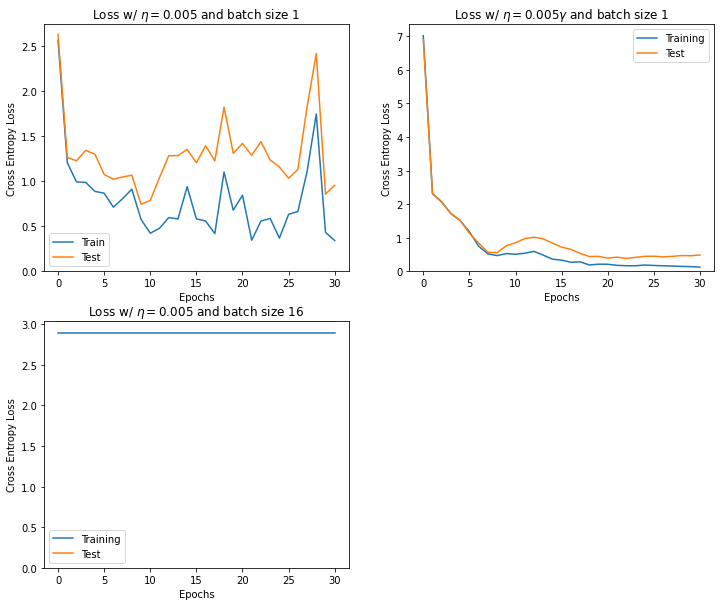

In [37]:
figure(figsize=(12,10))
subplot(2,2,1)
plot(train_loss,label='Train')
plot(test_loss,label='Test')
ylim(ymin=0)
title('Loss w/ $\eta=0.005$ and batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')
legend()

subplot(2,2,2)
plot(train_loss2,label='Training')
plot(test_loss2,label='Test')
ylim(ymin=0)
title('Loss w/ $\eta=0.005\gamma$ and batch size 1')
xlabel('Epochs')
ylabel('Cross Entropy Loss')

legend()

subplot(2,2,3)
plot(train_loss3,label='Training')
plot(test_loss3,label='Test')
ylim(ymin=0)
title('Loss w/ $\eta=0.005$ and batch size 16')
xlabel('Epochs')
ylabel('Cross Entropy Loss')


legend()